# E20. 어라, 이 시계열 데이터 이상한데? - Anomaly Detection

## 필요한 모듈 import

In [1]:
import datetime

import requests
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import ztest

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import copy

## 데이터를 무조건 믿으면 안 되는 이유
* 단계별 위험
    - 생성·측정 단계
        - 관측자의 실수 (휴먼 에러)
        - 측정 장비 오류
    - 수집·전달 단계
        - 데이터 수집 프로그램의 오류 (버그)
        - 데이터 관리자의 실수 (휴먼 에러) -> 실무에서 가장 흔한 데이터 오염
        - 데이터 전달 프로그램의 오류 (Open API)
* 이상한 데이터를 찾아내는 방법: Anomaly Detection
    - 다시 측정
    - 같은 데이터의 다른 출처를 찾아 비교 (supervised)
        1. 각 데이터를 비교해 다른 데이터를 찾고, 서로 같은 데이터는 정상으로 분류
        2. 서로 다른 데이터 중 '더 이상한' 데이터를 이상치로 분류
        3. 라벨링된 분류 결과로 이상치 탐색 모델 학습
    - 데이터 스스로의 특징을 활용해 찾아냄 (unsupervised)
        1. 데이터 스스로의 특징 분석
        2. 특정 기준보다 '더 이상한' 데이터를 이상치로 분류

## time series 데이터 불러오기
```
$ pip install requests
```
* 용어 설명 (https://jjeongil.tistory.com/656)
    - open 시가
    - high 고가
    - low 저가
    - close 종가
    - volume 거래량
    - Adj Close 주식의 분할, 배당, 배분 등을 고려해 보정한 종가

In [2]:
# 아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

# 데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = 'anomaly_detection/kospi/kospi.csv'

# response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:  
    fp.write(response.text)
    
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)
# pd.df.loc https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
# df.loc['row_name']: 행 선택
# df.loc[:, 'col_name']: 열 선택

# 데이터의 정합성을 확인합니다
df.isna().sum() # 결측치만 150개

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

* 결측 데이터 처리 방법
    1. 보간 (interpolation): 결측치 주변 데이터를 이용
    2. 삭제: dropna() https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

삭제 전 데이터 길이(일자수): 5842
삭제 후 데이터 길이(일자수): 5692


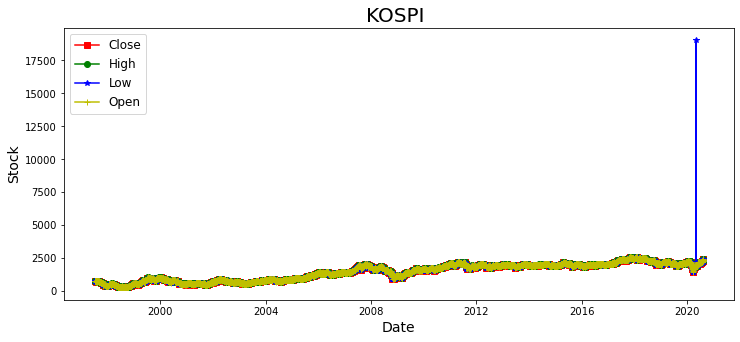

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

# 파란색이 low, 초록색이 high
plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show() # 2020년에 솟아있는 스파이크 (spike)

In [5]:
# 2020년에 솟아있는 스파이크 항목 확인
df.loc[df.Low > df.High] # 파란색 (low) 이 초록색 (high) 보다 높은 항목 확인

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


## outlier / novelties 구분하기
* Anomaly Detection: 이상치 (anomalies) 를 찾아내는 방법
* 이상치의 구분
    - 극단치 (outlier): 통계적 자료분석의 결과를 왜곡시키거나, 자료 분석의 적절성을 위협하는 변수값 또는 사례. 일반적으로 단변량 분석의 결과로 찾아낼 수 있으며, 교정하지 않으면 자료 분석에 방해가 됨
    - 특이치 (novelties): 정상적인 수집 과정에 의한 이상치. 이전까지는 보지 못한 패턴이나 데이터 (우리가 모르는 도메인의 변화) 가 이에 해당. 일반적으로 다변량 분석의 결과로 찾아낼 수 있음 (예: 코스피에서의 코로나 사태로 인한 주가 폭락)
* 대응 방안
    - 극단치
        - 참값으로 대체
        - 보간으로 대체
        - 삭제
    - 특이치
        - 극단치와 다르게 원본 데이터를 수정하지 않음
        - 남겨둬야 나중에 모델이 또 다른 특이치 발생 시 대응할 수 있기 때문
* https://arxiv.org/abs/1901.03407
* https://hoya012.github.io/blog/anomaly-detection-overview-1/

In [6]:
# 카카오 주식차트 결과로 대체합니다. 
df.loc[df.Date == '2020-05-06', 'Low'] = 1903 

# 비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low>df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


## 전통적 방법으로 이상 데이터를 찾아보자
* 데이터가 정규분포를 따른다면, 대부분의 데이터가 신뢰구간 안에 있을 것이고 그 밖에 있는 데이터는 이상치라고 생각할 수 있다.
    - (2σ를 기준으로 판단하면) 95.5%는 정상데이터, 4.5%는 이상치, 
    - (3σ를 기준으로 판단하면) 99.7%는 정상데이터, 0.27%는 이상치로 분류할 수 있다

### z-test: 정규분포를 따르는지 확인하는 방법
* p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다는 뜻이에요.
* 즉, 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어려워요
* 그렇다면 이 데이터에 대해서는 정규분포를 가정한 신뢰구간 분석은 적용하기 어려울 것입니다.

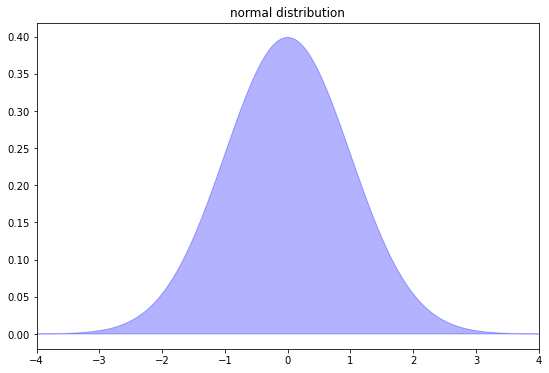

In [7]:
# 코스피 데이터 그래프로 확인

%matplotlib inline

x = np.arange(-5, 5, 0.001) # (start, stop, step) https://numpy.org/doc/stable/reference/generated/numpy.arange.html
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

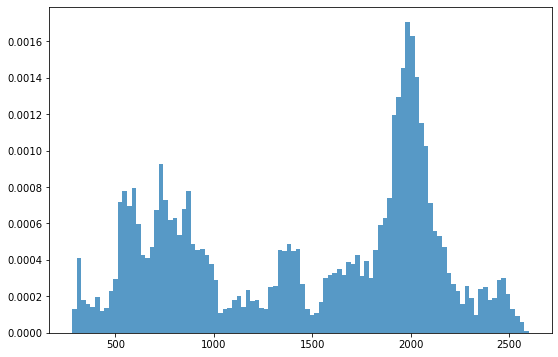

In [8]:
# 종가 데이터 확인: 육안으로 보기엔 정규분포라고 하기 어렵다

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [9]:
# z-test 방법으로 단변수의 정규분포 여부 확인

_, p = ztest(df.Close)
print(p)

0.0


### time series decomposition: 시계열 데이터 중 정규분포에 가까운 데이터를 뽑아내는 방법
```
$ pip install statsmodels
```
> 아마도 여러분은 Stationary (정상성)과 Time series decomposition(시계열 분해)에 대해서 배운 적이 있을 것입니다. Time series decomposition을 통해 시계열 데이터는 3가지 성분으로 분리되고, 그중 Residual 데이터는 Stationary에 가까운 형태를 가져요. 그리고 Stationary에 가까운 데이터는 정규분포를 따르지요! 우리는 이 Residual 데이터를 사용해서 신뢰구간을 구할 수 있어요.
   
* https://rfriend.tistory.com/510
* 시계열 데이터의 3가지 패턴
    - 추세 (순환) (trend)
    - 계절성 (seasonality)
    - 잔차 (residual)
* time series decomposition의 2가지 방법 (https://online.stat.psu.edu/stat510/lesson/5/5.1)
    - addictive: Observed[t] = trend[t] + seasonal[t] + resid[t]
    - multiplicative: Observed[t] = trend[t] * seasonal[t] * resid[t] (양변에 로그 취하면 addictive와 동일한 결과)
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    - two_sided: Trend 성분을 만들기 위해 freq 길이에 해당하는 샘플이 필요합니다. 이걸 rolling window로 만들어냅니다. 우리의 예제에서는 period=50 이기 때문에 two_sided=True라면 049번째 데이터로 25번째 Trend값을, 150번째 데이터로 26번째 Trend값을 생성합니다. two_sided=False라면 049번째 데이터로 50번째 Trend값을, 150번째 데이터로 51번째 Trend값을 생성합니다.
    - extrapolate_trend: 위의 Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생합니다. 우리의 예제에서는 period=50 이기 때문에 two_sided=True라면 맨앞에서 25개, 맨뒤에서 25개가 Nan이고, two_sided=False라면 맨앞에서 50개가 Nan입니다. 이렇게 발생하는 Nan 값을 채워주는 옵션이 extraplate_trend 입니다. 이 옵션을 빼면 Trend와 Resid에 Nan 값들이 생깁니다.

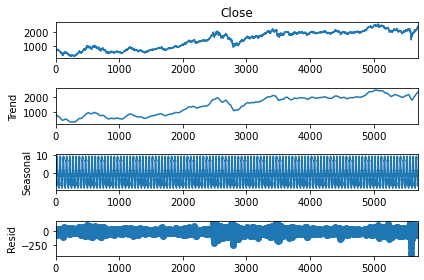

In [10]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분은 임의로 50일로 가정
result.plot()
plt.show()

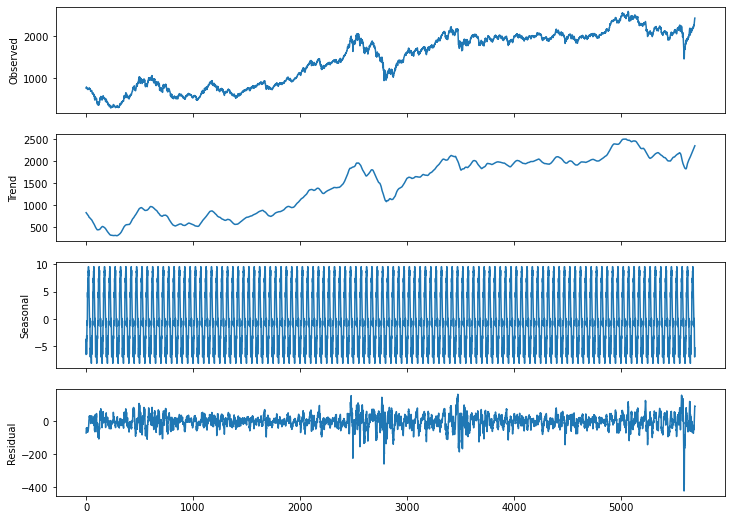

In [11]:
# 그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

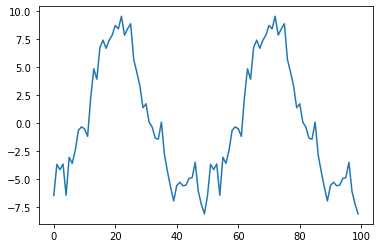

In [12]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot() # -8 에서 10 사이를 주기적으로 반복하는게 보이네요.

* 우리는 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶었어요
* 추세Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 볼까요?
* 잔차는 평균 0을 기준으로 분포하고 있어요!
* 잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?
* 그럼 Residual의 분포를 그려보도록 하겠습니다

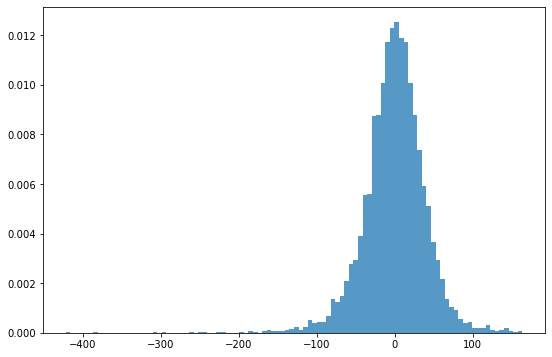

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75) # 정규분포의 형태

In [14]:
# z-test로 숫자 확인: p-value가 0.05 이상으로 강하게 나타남. 데이터가 정규분포를 따르고 있다는 뜻

r = result.resid.values
st, p = ztest(r)
print(st,p) # tstat, pvalue 순: https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html

-0.6804023554131796 0.4962497300226193


### 3σ 기준 신뢰구간으로 이상치 찾기

In [15]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)])) # 71개

# 이상치 확인
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

평균: -0.3595321143716522 표준편차: 39.8661527194307
이상치 갯수: 71


2475   2007-07-20
2476   2007-07-23
2477   2007-07-24
2478   2007-07-25
2493   2007-08-16
          ...    
5595   2020-03-26
5596   2020-03-27
5597   2020-03-30
5599   2020-04-01
5642   2020-06-05
Name: Date, Length: 71, dtype: datetime64[ns]

### 다변량 이상치 탐색 (Multi-variable Anomaly Detection)
> 신뢰구간 방법에서는 종가Close 하나의 지표만 활용해서 이상치를 찾아냈거든요. 다른 지표별로 분석해보면 71개가 아니라 몇백개를 찾아봐야할 수도 있어요.
   
* Multi-variable Anomaly Detection: 다양한 데이터로 더 그럴싸한 anomalies를 찾아낸 다음, 노가다를 최소한으로 하는 방법. 일반적으로 두 가지 알고리즘을 활용
    - clustering: 클러스터링으로 묶으면 정상인 데이터끼리 이상한 애들끼리 그룹핑되니 이상한 그룹을 찾는다.
    - forecasting: 시계열 예측모델을 만들어서, 예측오차가 크게 발생하는 지점은 이상한 상황이다. 일반적으로 Auto-Encoder로 탐색한다.

## 클러스터링으로 이상치 찾기: k-means와 DBSCAN
* k-means 와 DBSCAN 은 대표적인 unsupervised clustering 알고리즘이에요.
* 입력된 데이터들을 유사한 몇개의 그룹으로 분류해줍니다.
* k-means 은 몇개의 그룹으로 묶는지 지정할 수 있는 반면, DBSCAN은 지정할 수 없어요.

### 데이터 전처리
* open / high / low / close / volume 5가지 데이터 모두 사용
* trend, seasonal 성분 제거
* 5가지 데이터 모두 time series decomposition 전처리

In [16]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1463.295208,1472.280870,1452.027319,1462.541972,4.329729e+06
std,624.964914,625.522910,623.305110,624.550682,9.936646e+06
min,313.251601,317.456402,309.410898,313.594600,0.000000e+00
25%,829.229831,836.772549,819.689776,828.144798,3.367350e+05
50%,1650.375197,1658.997451,1638.522701,1650.718854,4.346625e+05
75%,1994.399103,2000.893924,1983.265902,1992.919778,6.528442e+05
max,2507.482712,2517.003208,2493.430989,2503.484602,4.516467e+07


In [17]:
rdf.describe() # volume만 숫자가 너무 크기 때문에, 표준정규화 필요

,Open,High,Low,Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,-0.401850,-0.380359,-0.398749,-0.374020,-1.954065e+02
std,39.589372,38.056752,40.809778,39.872618,8.934869e+06
min,-394.565789,-376.338461,-411.696607,-421.422951,-2.263667e+07
25%,-21.485369,-21.030832,-21.286770,-21.477541,-2.797035e+04
50%,1.389063,1.204421,1.788349,1.088418,1.945293e+05
75%,22.442679,21.891495,23.113944,22.650363,3.611476e+05
max,166.548008,151.359456,168.724502,163.663209,3.950393e+08


In [18]:
# 표준정규화 (한쪽에 쏠리는 걸 제외하기 위해)

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[  -0.40184982   -0.38035856   -0.39874878   -0.37402025 -195.40645742]


array([[-2.11078435e+00, -1.81469803e+00, -2.05551226e+00,
        -1.78975878e+00,  2.10763080e-02],
       [-1.57245471e+00, -1.31620670e+00, -1.54326110e+00,
        -1.29206209e+00,  3.44552935e-03],
       [-1.16743672e+00, -1.15447694e+00, -1.25272255e+00,
        -1.24664060e+00, -1.95018959e-04],
       ...,
       [ 1.40187705e+00,  2.03518846e+00,  1.80321776e+00,
         2.10596922e+00,  6.12871509e-02],
       [ 1.72956122e+00,  1.93639106e+00,  1.59747384e+00,
         2.26635573e+00,  3.75265169e-02],
       [ 2.56782539e+00,  2.43952406e+00,  1.89411956e+00,
         2.24061341e+00,  1.51850684e-02]])

### k-means로 이상치 탐색
* 소수그룹이 형성될 만큼 충분한 그룹수로 클러스터링 한다
* 소수그룹의 특징을 분석한다
* 해당 소수그룹들이 이상치인지 추론해본다.
* (참고) https://ratsgo.github.io/machine%20learning/2017/04/19/KC/

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/glossary.html#term-random-state
# "k-means는 난수를 이용하기 때문에 실행할 때마다 결과가 다를수 있어요.
# 그래서 동일한 분석결과를 얻기 위해서는 난수설정값을 통일시켜주는 과정이 필요합니다.
# np.random.seed() 와 비슷한 역할을 하는 코드에요.

[1 1 1 ... 0 0 0]


In [20]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[3258 2434]


In [21]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1002',
 'group:1-count:535',
 'group:2-count:47',
 'group:3-count:2',
 'group:4-count:336',
 'group:5-count:868',
 'group:6-count:210',
 'group:7-count:820',
 'group:8-count:8',
 'group:9-count:142',
 'group:10-count:1007',
 'group:11-count:55',
 'group:12-count:2',
 'group:13-count:591',
 'group:14-count:67']

### 이상치 분석

#### 어떤 날들이 분류된 건지

In [22]:
# TODO: 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==8)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
1607,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
2737,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0
2738,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0
2786,2008-10-27,937.179993,966.409973,892.159973,946.450012,946.450012,540600.0
2787,2008-10-28,916.849976,1012.729980,901.489990,999.159973,999.159973,649400.0
5588,2020-03-17,1640.839966,1722.969971,1637.880005,1672.439941,1672.439941,649800.0
5589,2020-03-18,1686.119995,1693.949951,1591.119995,1591.199951,1591.199951,728000.0
5590,2020-03-19,1626.089966,1626.089966,1439.430054,1457.640015,1457.640015,977700.0
5591,2020-03-20,1498.489990,1566.819946,1466.479980,1566.150024,1566.150024,817000.0


In [23]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5692.000000,5692.000000,5692.000000,5692.000000,5692.000000,5.692000e+03
mean,1462.901104,1471.908189,1451.636816,1462.175989,1462.175989,4.329776e+06
std,627.457157,627.898094,625.928464,627.087928,627.087928,1.351615e+07
min,283.410004,291.010010,277.369995,280.000000,280.000000,0.000000e+00
25%,827.972473,836.750000,815.689987,826.737503,826.737503,3.126000e+05
50%,1652.270019,1658.365051,1633.690002,1646.915039,1646.915039,4.103000e+05
75%,1999.605011,2006.892517,1988.862488,1997.255005,1997.255005,6.145500e+05
max,2590.409912,2607.100098,2587.550049,2598.189941,2598.189941,4.071570e+08


In [24]:
# 2004-04-14 주변 정황
df.iloc[1660:1670]

,Date,Open,High,Low,Close,Adj Close,Volume
1660,2004-04-09,910.479980,910.479980,901.239990,905.440002,905.440002,352200.0
1661,2004-04-12,905.440002,926.070007,905.440002,918.859985,918.859985,366200.0
1662,2004-04-13,925.190002,927.669983,916.200012,917.630005,917.630005,469000.0
1663,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0
1664,2004-04-16,903.840027,908.719971,897.729980,898.880005,898.880005,391800.0
1665,2004-04-19,900.479980,902.099976,891.270020,902.099976,902.099976,476200.0
1666,2004-04-20,909.909973,919.130005,902.469971,918.900024,918.900024,456800.0
1667,2004-04-21,910.679993,931.210022,910.679993,929.950012,929.950012,554000.0
1668,2004-04-22,931.090027,933.840027,921.969971,924.010010,924.010010,519800.0
1669,2004-04-23,938.250000,939.520020,929.799988,936.059998,936.059998,480400.0


#### 각 그룹은 어떤 특징을 갖고 있는지
* 다른 그룹들은 거래량 값이 매우 작지만, 2개 그룹의 거래량 (volume) 수치가 유독 큽니다.
* 그리고 Open, High, Low, Close의 값이 유독 낮은 그룹이 하나 있습니다.

In [25]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])
# kmeans.cluster_centers_: kmeans 중심값들 https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

,Open,High,Low,Close,Volume
0,-0.082112,-0.092739,-0.078163,-0.087114,-0.063000
1,1.144757,1.164607,1.126808,1.133456,0.008482
2,-3.345688,-3.302405,-3.670760,-3.494020,0.004189
3,1.404885,1.474385,1.540287,1.527861,27.050550
4,-1.406206,-1.450260,-1.419465,-1.434598,-0.102974
5,-0.466282,-0.483060,-0.456106,-0.459764,-0.060207
6,1.765868,1.834539,1.780621,1.788096,0.117591
7,0.665708,0.683950,0.669692,0.672248,-0.025536
8,-7.397073,-6.966336,-7.659620,-7.181657,-0.037365
9,-2.175945,-2.210252,-2.189755,-2.158304,-0.121632


#### 왜 이상치로 분류된 걸까?
* 거래량이 비정상적인 두 그룹: ```df.describe()```에서 알아본 평균 거래량 (4,329,776) 보다 60배 이상 많은 250,000,000
    - 야후 파이낸스의 실수: https://kr.investing.com/indices/kospi-historical-data 다른 데이터와 비교해보면, 1000으로 나눠야
* 값들이 유독 낮은 한 그룹: 코스피 역사상 가장 큰 폭락장

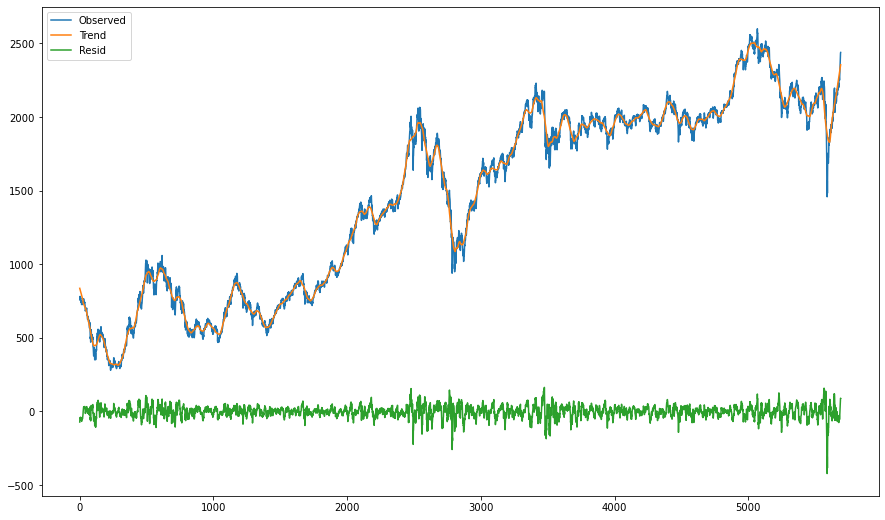

In [26]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax, label='Resid', legend=True)
plt.show()

### DBSCAN으로 이상치 찾기
* DBSCAN은 k-means와 달리 클러스터 수 지정할 필요 없음
* 아주 간단히 말해서, DBSCAN 알고리즘은 핵심벡터와 일정 거리 ϵ 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데, 그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터 (노이즈 벡터) 찾는 일
* https://gentlej90.tistory.com/29

In [27]:
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [28]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[0 0 0 ... 0 0 0]


In [29]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)] # 41개, 3개, 2개의 소수그룹으로 분류됨

['group:-1-count:41',
 'group:0-count:5646',
 'group:1-count:3',
 'group:2-count:2']

## Auto-Encoder를 이용한 이상치 탐색
* 앞의 예제들의 기본 로직은 동일
    - Time series decomposition 을 이용해 Trend/Seasonal/Residual 값으로 분리한다
    - Residual 값의 분포를 이용해서 이상치를 탐지해낸다
* 통계적 방법과 Unsupervised 기법의 장점
    - 적은 샘플 수로도 분석이 가능하다 (샘플 수가 50개 이상이면 적용 가능)
    - 하드웨어 제약이 거의 없다
* 통계적 방법과 Unsupervised 기법의 단점
    - Time series decomposition에 의존해야한다는 점
    - 분석자의 주관이 필요하다는 단점이 있었습니다.
    - (통계기법:몇 배수의 표준편차?, k-means:몇개 그룹으로 클러스터링?, Time Series decompose: freq는 몇으로?)
* 딥러닝 이상치 탐색의 장점
    - Time series decompostion 없이 분석 수행이 가능하다
    - Trend, Seasonal 데이터를 포함하고 있기 때문에 Trend, Seasonal의 변화도 이상치로써 탐색이 가능하다
* 딥러닝 이상치 탐색의 단점
    - 분석자의 주관이 어느정도 필요하긴 하다 (Threshold, window)
    - 학습에 활용할 만큼 충분한 데이터가 확보되어야한다.
* https://keras.io/examples/timeseries/timeseries_anomaly_detection/

### 오토인코더란?
* 인코더와 디코더로 구성
    - 인코더: 입력 데이터로부터 중요한 정보 (compressed feature vector) 를 뽑아낸다. 이 과정에서 입력 데이터보다 압축된 형태의 데이터를 얻는다
    - 디코더: 중요한 정보로 입력 데이터와 유사한 형태를 재생성
* 인코더가 중요한 정보를 '잘' 뽑아내면, 디코더는 입력 데이터를 거의 똑같이 생성해낼 수 있을 것
* (참고) https://sunghan-kim.github.io/ml/3min-dl-ch08/#81-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94-%EA%B0%9C%EB%85%90
* (참고) https://excelsior-cjh.tistory.com/187
* (참고) https://eat-toast.tistory.com/4 입력과 출력이 동일한데 무슨 의미가 있을까?
* (참고) https://wikidocs.net/3413

In [30]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

### LSTM을 이용한 오토인코더 만들기

#### 데이터 전처리
* (가장 일반적인) 표준정규분포로 전처리: 입력 변수를 정규화해야 딥러닝 모델 학습이 원활하기 때문

In [31]:
# 데이터 전처리 - 하이퍼파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

#### 데이터셋 만들기 (keras의 ```TimeseriesGenerator``` 활용)
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator
    - data: 입력 데이터 (x)를 넣어줍니다. 우리는 'Open','High','Low','Close','Volume' 5가지 인풋을 사용합니다.
    - targets: 출력 데이터를 넣어줍니다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한 걸 넣어줍니다.
    - length: 몇개의 time_step을 참고할지 입력합니다.
    - stride: time_step 사이즈를 결정합니다.

In [32]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


#### 모델 만들기
* 2개 층의 LSTM으로 인코더를 만듭니다.
    - (참고) RNN과 LSTM: https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
    - (참고) https://m.blog.naver.com/PostView.nhn?blogId=magnking&logNo=221311273459
    - (참고) https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
    - (참고) https://taeu.github.io/nlp/deeplearning-nlp-rnn/
* RepeatVector는 input을 window_size 만큼 복사해줍니다.

In [33]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [34]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
epochs = 50

checkpoint_path = 'anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mae', optimizer='adam',metrics=["mae"])

hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=epochs, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
177/178 [============================>.] - ETA: 0s - loss: 0.6256 - mae: 0.6256
Epoch 00001: val_loss improved from inf to 0.06436, saving model to anomaly_detection/kospi/mymodel.ckpt
178/178 [==============================] - 5s 28ms/step - loss: 0.6249 - mae: 0.6249 - val_loss: 0.0644 - val_mae: 0.0644
Epoch 2/50
176/178 [============================>.] - ETA: 0s - loss: 0.1790 - mae: 0.1790
Epoch 00002: val_loss did not improve from 0.06436
178/178 [==============================] - 5s 26ms/step - loss: 0.1779 - mae: 0.1779 - val_loss: 0.0707 - val_mae: 0.0707
Epoch 3/50
177/178 [============================>.] - ETA: 0s - loss: 0.1357 - mae: 0.1357
Epoch 00003: val_loss did not improve from 0.06436
178/178 [==============================] - 5s 27ms/step - loss: 0.1354 - mae: 0.1354 - val_loss: 0.0846 - val_mae: 0.0846
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.1256 - mae: 0.1256
Epoch 00004: val_loss improved from 0.06436 to 0.06351, saving 

In [35]:
model.load_weights(checkpoint_path)

#### 학습 과정 확인
* 안정적으로 Training loss 가 수렴하고, Validation loss 가 발산하지 않음을 확인

> **주의**: 우리는 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델을 만들었어요. 그래서 train_gen의 길이는 원본 df의 길이보다 window_size 만큼 짧습니다. 예측 결과와 비교할 때는 **scaled의 앞에서 window_size 만큼을 건너뛰어야 해요.**

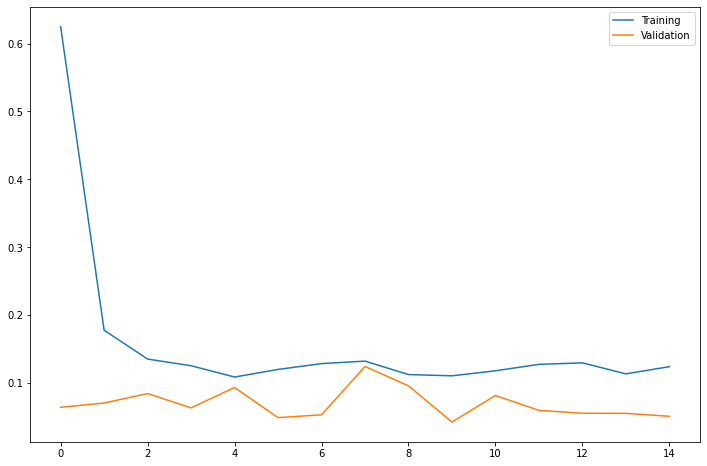

In [36]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

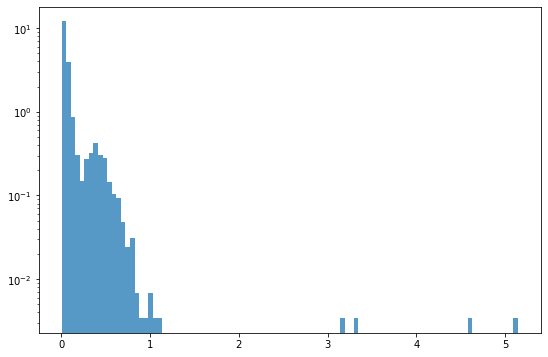

In [37]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

### ```mae_loss```가 3 이상으로 동떨어진 샘플
* 그래프 상 육안으로 봐도 3 이후에 멀리 떨어진 샘플들 확인 가능
* mae_loss의 기준치 (threshold) 를 3으로 설정해 확인
* ```scaled``` 는 조정된 데이터이므로 원본 데이터인 ```df``` 와 비교 

In [38]:
# 기존의 df와 mae_loss 까지 합쳐서 분석하기 위한 데이터프레임 생성
test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold] # 그래프에서 확인되는 이상치 4개 출력됨

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1597,2004-01-20,854.030029,864.260010,853.049988,861.369995,861.369995,364449900.0,4.616491
1653,2004-04-14,909.950012,919.380005,907.359985,916.309998,916.309998,407157000.0,5.144424
2727,2008-08-14,1553.650024,1578.300049,1553.650024,1572.189941,1572.189941,247586000.0,3.160294
2728,2008-08-18,1579.130005,1582.760010,1561.569946,1567.709961,1567.709961,260725000.0,3.311971


In [39]:
# 기준치를 낮춰서 더 많은 이상치 찾기
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
321,1998-11-06,419.339996,436.119995,416.070007,416.299988,416.299988,23351200.0,0.308897
331,1998-11-20,443.339996,464.119995,440.869995,452.929993,452.929993,24318600.0,0.339026
334,1998-11-25,461.269989,467.130005,457.869995,461.010010,461.010010,22086300.0,0.310381
337,1998-11-30,455.440002,461.160004,450.130005,451.880005,451.880005,23835300.0,0.306933
341,1998-12-04,449.149994,466.339996,446.820007,466.339996,466.339996,24484100.0,0.309746
...,...,...,...,...,...,...,...,...
5578,2020-03-17,1640.839966,1722.969971,1637.880005,1672.439941,1672.439941,649800.0,0.392922
5579,2020-03-18,1686.119995,1693.949951,1591.119995,1591.199951,1591.199951,728000.0,0.371789
5580,2020-03-19,1626.089966,1626.089966,1439.430054,1457.640015,1457.640015,977700.0,0.466172
5581,2020-03-20,1498.489990,1566.819946,1466.479980,1566.150024,1566.150024,817000.0,0.403816


#### 그래프로 그려서 이상치 찾아보기
* Open, Close, Low, High 같은 데이터는 스케일이 비슷하니 한번에 그려도 좋을 거에요
* 하지만 Volume과 loss는 스케일이 다르니 각각 그래프를 그려봐요
* 기준치로 분류해낸 이상치들은 붉은 점으로 그려서 나타내요

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


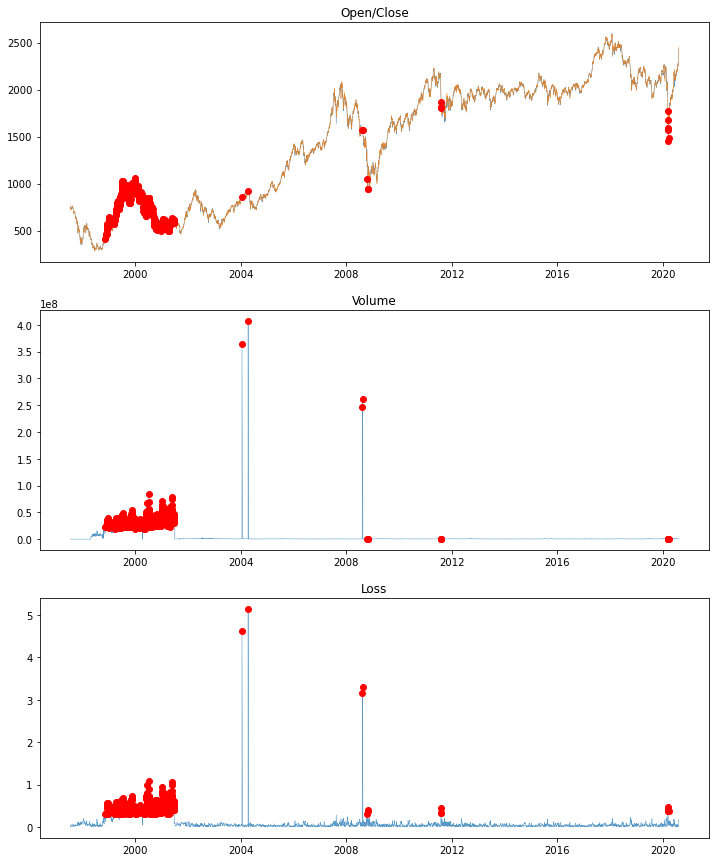

In [40]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

## 미니 프로젝트: 다른 시계열 데이터에서 이상치 찾기

### 데이터 구하기
* https://finance.yahoo.com/quote/NQ=F?p=NQ=F

In [41]:
csv_file_n = 'anomaly_detection/nasdaq/NQ=F.csv'

df_n = pd.read_csv(csv_file_n)
df_n.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [42]:
df_n.loc[:,'Date'] = pd.to_datetime(df_n.Date) # 날짜 형식 변환
df_n.isna().sum() # 결측치 확인

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [43]:
print("삭제 전 데이터 길이(일자수):",len(df_n))
df_n = df_n.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df_n))
df_n.isna().sum()

삭제 전 데이터 길이(일자수): 6169
삭제 후 데이터 길이(일자수): 5097


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

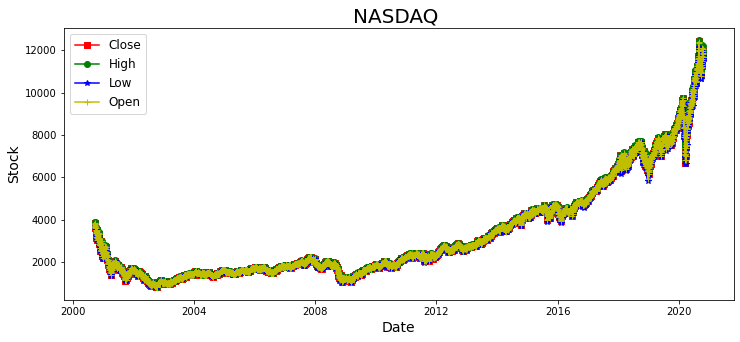

In [44]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

# 파란색이 low, 초록색이 high
plt.plot(df_n.Date, df_n.Close, marker='s', color='r')
plt.plot(df_n.Date, df_n.High, marker='o', color='g')
plt.plot(df_n.Date, df_n.Low, marker='*', color='b')
plt.plot(df_n.Date, df_n.Open, marker='+', color='y')

plt.title('NASDAQ ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

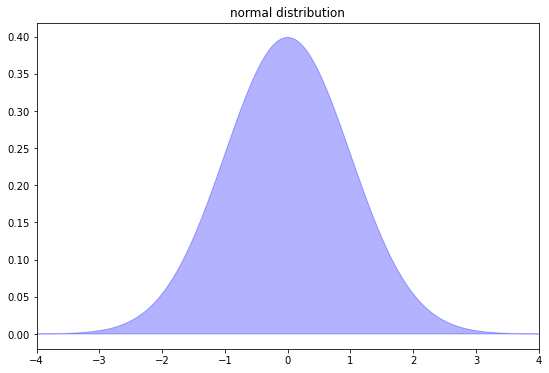

In [45]:
%matplotlib inline

x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

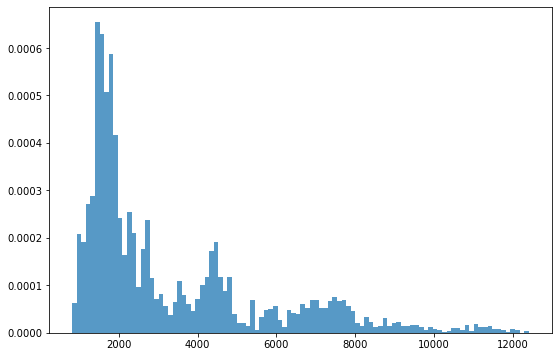

In [46]:
# 종가 데이터 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df_n.Close, 100, density=True, alpha=0.75)

In [47]:
# z-test 방법으로 단변수의 정규분포 여부 확인

_, p = ztest(df_n.Close)
print(p)

0.0


* 이 나스닥 데이터의 분포는 정규분포라고 보기 어렵다. time series decompose 수행 후 residual로 분석해보자.

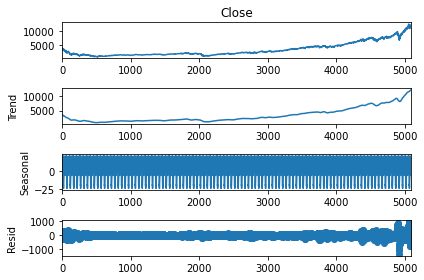

In [48]:
result_n = seasonal_decompose(df_n.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분은 임의로 50일로 가정
result_n.plot()
plt.show()

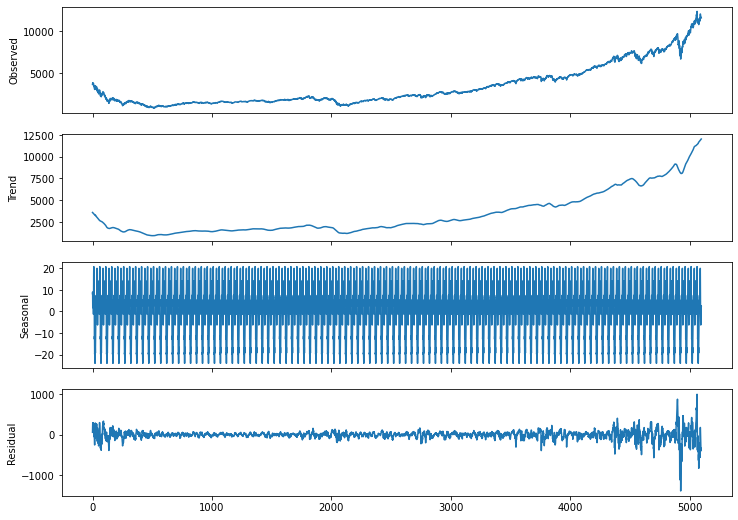

In [49]:
# 그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_n.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_n.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_n.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_n.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

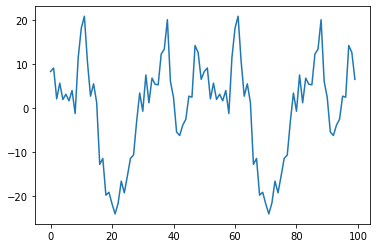

In [50]:
# seasonal 일부만 잘라 패턴 확인
result_n.seasonal[:100].plot()

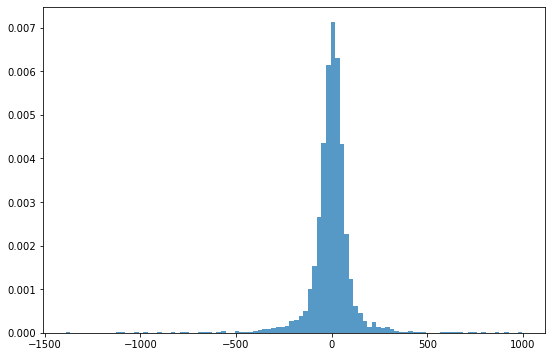

In [51]:
# residual 분포 그려보기
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result_n.resid, 100, density=True, alpha=0.75) # 정규분포의 형태

In [52]:
# z-test로 residual의 p-value 확인: p-value가 0.05 이상으로 강하게 나타남. 데이터가 정규분포를 따르고 있다는 뜻

r = result_n.resid.values
st, p = ztest(r)
print(st,p)

-0.8522496995036497 0.39407551750052994


### 이상치 찾기

#### 1. 3σ 기준 신뢰구간으로 이상치 찾기

In [54]:
# 평균과 표준편차 출력
mu, std = result_n.resid.mean(), result_n.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result_n.resid[(result_n.resid>mu+3*std)|(result_n.resid<mu-3*std)])) # 71개

# 이상치 확인
df_n.Date[result_n.resid[
    (result_n.resid>mu+3*std)|(result_n.resid<mu-3*std)].index]

평균: -1.313906361677976 표준편차: 110.0664287457301
이상치 갯수: 95


66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5086   2020-10-08
5093   2020-10-19
5094   2020-10-20
5095   2020-10-21
5096   2020-10-22
Name: Date, Length: 95, dtype: datetime64[ns]

#### 2. k-means

In [55]:
# 데이터 전처리
'''
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid
'''

# 각 변수별 트렌드/계절적/잔차
tdf_n, sdf_n, rdf_n = my_decompose(df_n, features=['Open','High','Low','Close','Volume'])
tdf_n.describe()

,Open,High,Low,Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000
mean,3329.118618,3360.581337,3296.950210,3330.997045,287988.011319
std,2398.388176,2420.273190,2377.217548,2402.305499,109739.725261
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.340000,1597.610000,1571.100000,1584.276001,220570.770000
50%,2264.705000,2291.690000,2232.192500,2264.982500,268897.250000
75%,4433.907500,4465.685000,4400.967500,4435.272500,319670.180000
max,12046.249464,12205.163635,11877.272025,12052.571806,776809.340000


In [56]:
rdf_n.describe() # volume만 숫자가 너무 크기 때문에, 표준정규화 필요

,Open,High,Low,Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000
mean,-1.389481,-1.415631,-1.275371,-1.334106,162.468983
std,112.458034,102.142678,116.646385,110.222420,110730.691639
min,-1280.483047,-1494.583444,-1226.888145,-1390.096658,-602954.910733
25%,-38.123741,-35.277082,-38.410498,-37.721638,-53334.836389
50%,3.432113,3.376359,4.072309,2.958272,-492.600487
75%,40.282673,37.530846,41.728350,40.844126,51622.953177
max,996.926304,933.615919,941.529412,996.300897,810720.467889


In [57]:
# 표준정규화 (한쪽에 쏠리는 걸 제외하기 위해)

scaler = StandardScaler()
scaler.fit(rdf_n)
print(scaler.mean_)
norm_rdf_n = scaler.transform(rdf_n)
norm_rdf_n

[ -1.38948086  -1.41563149  -1.27537141  -1.33410601 162.46898264]


array([[ 0.94716208,  0.84570641,  0.8160061 ,  0.6009286 ,  0.08320764],
       [ 0.48936005,  1.283057  ,  1.3862533 ,  2.09233495,  0.10452471],
       [ 1.90396838,  2.01658117,  2.04492858,  2.73371252, -0.08886621],
       ...,
       [-2.74272049, -3.62515399, -2.08239522, -3.19840343,  0.6827219 ],
       [-3.13456834, -3.96398901, -2.38015451, -3.13021572,  0.47180826],
       [-3.23218209, -4.66061227, -3.20590445, -3.66350521,  0.56377243]])

In [58]:
kmeans_n = KMeans(n_clusters=15, random_state=0).fit(norm_rdf_n)
lbl, cnt = np.unique(kmeans_n.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:732',
 'group:1-count:1036',
 'group:2-count:261',
 'group:3-count:32',
 'group:4-count:98',
 'group:5-count:20',
 'group:6-count:286',
 'group:7-count:153',
 'group:8-count:11',
 'group:9-count:789',
 'group:10-count:104',
 'group:11-count:62',
 'group:12-count:846',
 'group:13-count:405',
 'group:14-count:262']

In [59]:
# TODO: 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df_n[(kmeans_n.labels_==3)|(kmeans_n.labels_==5)|(kmeans_n.labels_==8)]

,Date,Open,High,Low,Close,Adj Close,Volume
137,2001-04-04,1407.500000,1451.000000,1361.00,1379.500000,1379.500000,141811.0
4374,2018-02-09,6328.000000,6455.500000,6164.00,6417.750000,6417.750000,787495.0
4591,2018-12-26,5902.000000,6310.000000,5820.50,6285.500000,6285.500000,642440.0
4592,2018-12-27,6283.000000,6333.000000,6053.25,6323.500000,6323.500000,740129.0
4596,2019-01-03,6242.750000,6304.250000,6148.50,6162.000000,6162.000000,714536.0
...,...,...,...,...,...,...,...
5082,2020-10-02,11566.799805,11604.799805,11204.50,11233.200195,11233.200195,806629.0
5083,2020-10-05,11308.500000,11497.500000,11267.50,11469.200195,11469.200195,398444.0
5084,2020-10-06,11473.000000,11524.500000,11197.50,11273.799805,11273.799805,612278.0
5085,2020-10-07,11220.500000,11506.500000,11208.00,11470.000000,11470.000000,443046.0


In [60]:
df_n.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5097.000000,5097.000000,5097.000000,5097.000000,5097.000000,5.097000e+03
mean,3327.722521,3359.159792,3295.667440,3329.656394,3329.656394,2.881619e+05
std,2398.369859,2419.552584,2377.879993,2402.170957,2402.170957,1.595578e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.000000,1608.500000,1576.500000,1593.000000,1593.000000,1.907490e+05
50%,2231.000000,2259.750000,2211.500000,2232.250000,2232.250000,2.657150e+05
75%,4447.000000,4467.250000,4419.250000,4450.250000,4450.250000,3.561590e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [61]:
# 2001-04-04 주변 정황
df_n.iloc[130:140]

,Date,Open,High,Low,Close,Adj Close,Volume
130,2001-03-26,1738.5,1777.0,1685.5,1698.5,1698.5,94945.0
131,2001-03-27,1698.0,1774.0,1681.0,1753.5,1753.5,124465.0
132,2001-03-28,1751.0,1751.0,1606.5,1610.0,1610.0,111032.0
133,2001-03-29,1614.5,1647.0,1559.0,1580.0,1580.0,114157.0
134,2001-03-30,1585.0,1621.5,1544.5,1588.0,1588.0,100139.0
135,2001-04-02,1601.0,1625.0,1511.0,1517.0,1517.0,107903.0
136,2001-04-03,1521.5,1527.0,1402.0,1405.0,1405.0,132338.0
137,2001-04-04,1407.5,1451.0,1361.0,1379.5,1379.5,141811.0
138,2001-04-05,1390.0,1537.0,1382.0,1514.5,1514.5,132812.0
139,2001-04-06,1522.0,1544.0,1437.0,1467.0,1467.0,141183.0


In [62]:
# 2018-02-09 주변 정황
df_n.iloc[4370:4380]

,Date,Open,High,Low,Close,Adj Close,Volume
4370,2018-02-05,6752.25,6813.50,6387.75,6429.25,6429.25,931677.0
4371,2018-02-06,6473.00,6677.50,6260.25,6653.75,6653.75,813419.0
4372,2018-02-07,6638.00,6717.75,6532.00,6555.75,6555.75,593446.0
4373,2018-02-08,6542.00,6618.50,6301.00,6317.25,6317.25,640585.0
4374,2018-02-09,6328.00,6455.50,6164.00,6417.75,6417.75,787495.0
4375,2018-02-12,6434.50,6567.50,6414.25,6531.75,6531.75,406083.0
4376,2018-02-13,6529.75,6571.00,6470.75,6560.50,6560.50,382334.0
4377,2018-02-14,6559.50,6692.75,6456.25,6687.00,6687.00,482298.0
4378,2018-02-15,6681.00,6827.50,6669.75,6816.00,6816.00,458423.0
4379,2018-02-16,6816.25,6859.75,6762.00,6786.75,6786.75,445962.0


In [63]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans_n.cluster_centers_, columns=['Open','High','Low','Close','Volume'])
# kmeans.cluster_centers_: kmeans 중심값들 https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

,Open,High,Low,Close,Volume
0,-0.410044,-0.424229,-0.356549,-0.366108,-0.063781
1,0.101906,0.095874,0.147502,0.130155,-0.330136
2,1.069637,1.108876,1.157531,1.137764,-0.411966
3,-4.297818,-4.626367,-4.284899,-4.263661,0.710669
4,-2.198994,-2.249134,-2.115708,-2.116222,-0.175964
5,6.067089,6.117151,6.116227,6.036096,-0.222445
6,0.422347,0.423038,0.507370,0.495880,-1.633568
7,0.142768,0.096533,-0.357444,-0.306406,2.294580
8,-8.528182,-7.585937,-8.585452,-7.700270,-2.334964
9,0.512502,0.544999,0.512553,0.516380,0.065600


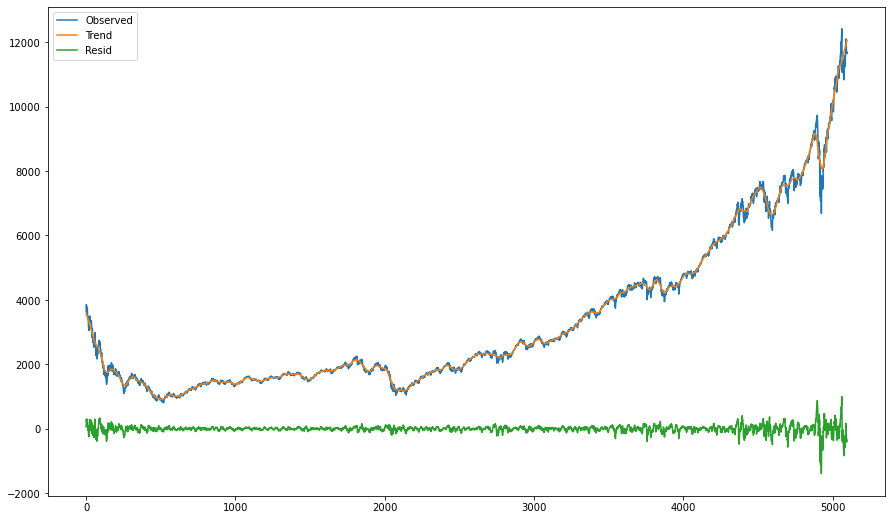

In [64]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df_n.Close.plot(ax=ax, label='Observed', legend=True)
tdf_n.Close.plot(ax=ax, label='Trend', legend=True)
rdf_n.Close.plot(ax=ax, label='Resid', legend=True)
plt.show()

#### 3. DBSCAN

In [65]:
clustering_n = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf_n)
clustering_n

DBSCAN(eps=0.7, min_samples=2)

In [66]:
print(clustering_n.labels_) # 분류된 라벨 확인

[ 0  0  0 ... 22 22 -1]


In [67]:
lbl, cnt = np.unique(clustering_n.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:198',
 'group:0-count:4840',
 'group:1-count:2',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:2',
 'group:22-count:3',
 'group:23-count:2']

#### 4. 오토인코더

In [68]:
# 데이터 전처리 - 하이퍼파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.
scaler = StandardScaler()
scaler = scaler.fit(df_n.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df_n[features].values)

In [69]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [70]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
__________________________________________________

In [71]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
epochs = 50

checkpoint_path_n = 'anomaly_detection/kospi/mymodel_n.ckpt'
checkpoint_n = ModelCheckpoint(checkpoint_path_n, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mae', optimizer='adam',metrics=["mae"])

hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=epochs, 
          callbacks=[checkpoint_n, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.2336 - mae: 1.2336
Epoch 00001: val_loss improved from inf to 4.17231, saving model to anomaly_detection/kospi/mymodel_n.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 1.2336 - mae: 1.2336 - val_loss: 4.1723 - val_mae: 4.1723
Epoch 2/50
158/159 [============================>.] - ETA: 0s - loss: 0.9881 - mae: 0.9881
Epoch 00002: val_loss improved from 4.17231 to 0.96982, saving model to anomaly_detection/kospi/mymodel_n.ckpt
159/159 [==============================] - 4s 26ms/step - loss: 0.9844 - mae: 0.9844 - val_loss: 0.9698 - val_mae: 0.9698
Epoch 3/50
158/159 [============================>.] - ETA: 0s - loss: 0.3937 - mae: 0.3937
Epoch 00003: val_loss improved from 0.96982 to 0.68878, saving model to anomaly_detection/kospi/mymodel_n.ckpt
159/159 [==============================] - 4s 27ms/step - loss: 0.3922 - mae: 0.3922 - val_loss: 0.6888 - val_mae: 0.6888
Epoch 4/50
158/159 [============

In [72]:
model.load_weights(checkpoint_path_n)

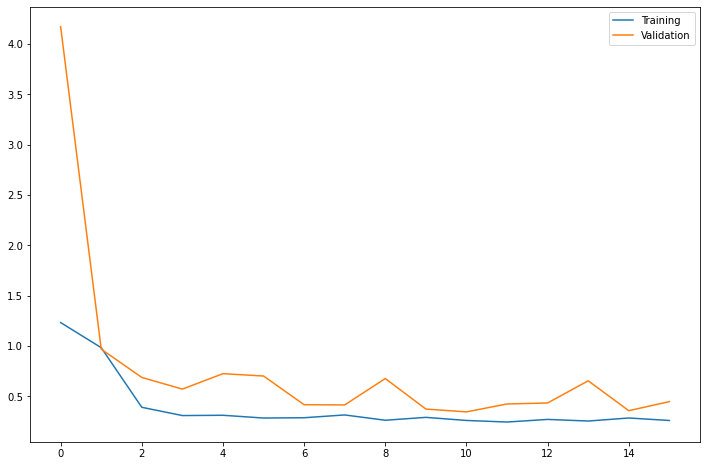

In [73]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

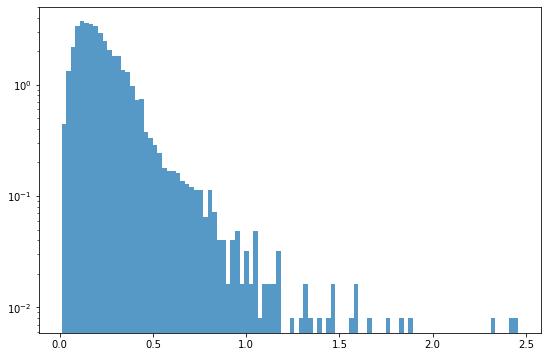

In [75]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [76]:
# 기존의 df와 mae_loss 까지 합쳐서 분석하기 위한 데이터프레임 생성
test_df_n = copy.deepcopy(df_n.loc[window_size:]).reset_index(drop=True)
test_df_n['Loss'] = mae_loss

threshold = 3
test_df_n.loc[test_df_n.Loss>threshold] # 그래프에서 확인되는 이상치 4개 출력됨

,Date,Open,High,Low,Close,Adj Close,Volume,Loss


In [77]:
# 기준치를 낮춰서 더 많은 이상치 찾기
threshold = 0.3
test_df_n.loc[test_df_n.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
0,2000-10-02,3621.000000,3668.000000,3492.000000,3528.500000,3528.500000,63100.0,0.303282
1,2000-10-03,3529.000000,3603.000000,3385.000000,3397.000000,3397.000000,78732.0,0.327574
2,2000-10-04,3426.500000,3477.500000,3334.000000,3477.500000,3477.500000,77551.0,0.348389
4,2000-10-06,3490.000000,3509.500000,3305.000000,3357.500000,3357.500000,69256.0,0.327007
5,2000-10-09,3359.500000,3402.000000,3222.000000,3349.500000,3349.500000,50998.0,0.391598
...,...,...,...,...,...,...,...,...
5078,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,0.802323
5079,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0,0.888439
5080,2020-10-14,12079.799805,12178.000000,11901.799805,11974.200195,11974.200195,597198.0,0.466131
5081,2020-10-15,11950.000000,11983.200195,11736.500000,11874.000000,11874.000000,595926.0,0.306760


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


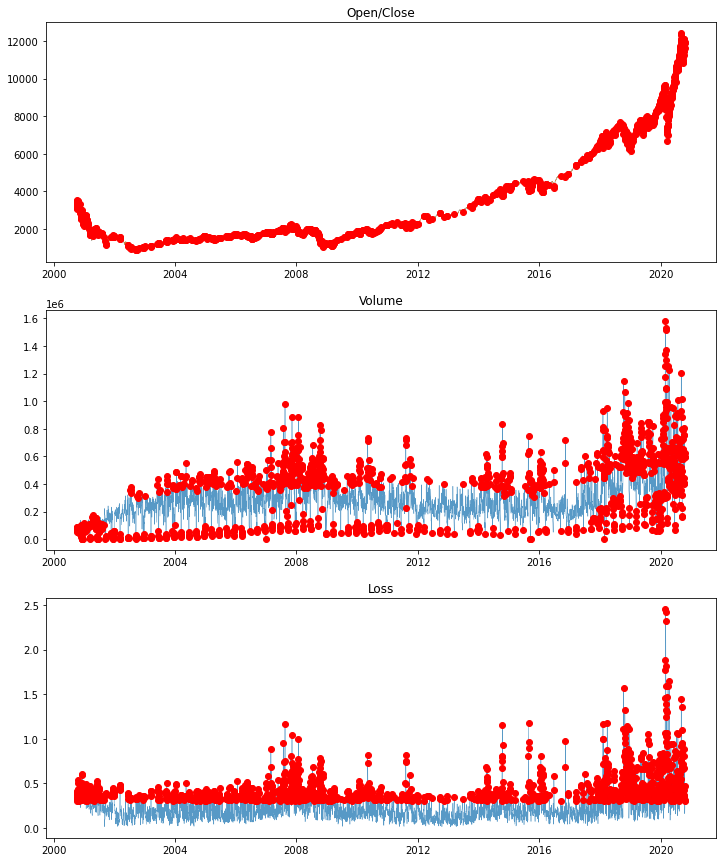

In [78]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df_n.Date, test_df_n.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df_n.Date, test_df_n.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df_n.Date, test_df_n.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df_n.Date, test_df_n.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df_n.Date, test_df_n.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df_n.Date, test_df_n.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df_n.Date, test_df_n.Loss, 'or', markevery=[mae_loss>threshold])